# Models Creation

In [2]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
print(sys.version)

3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:51:40) 
[GCC 13.3.0]


In [4]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-nightly, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 


In [5]:
import tensorflow as tf

2025-03-29 20:02:28.247657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/cv2/../../lib64:
2025-03-29 20:02:28.247681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [15]:
data = pd.read_csv("../data/ml/test.csv")

In [16]:
data

,Video,Evento,PCB,Start_Frame,End_Frame,duracion,Path,is_crime
0,Fighting051_x264.mp4,Fighting,989,1294,3355,2366,../data/test/Fighting051_x264.mp4,1
1,Normal_Videos086_x264.mp4,Normal,0,0,3391,3391,../data/test/Normal_Videos086_x264.mp4,0
2,Normal_Videos405_x264.mp4,Normal,0,0,1065,1065,../data/test/Normal_Videos405_x264.mp4,0
3,Normal_Videos134_x264.mp4,Normal,0,0,4476,4476,../data/test/Normal_Videos134_x264.mp4,0
4,Assault007_x264.mp4,Assault,330,668,1099,769,../data/test/Assault007_x264.mp4,1
...,...,...,...,...,...,...,...,...
60,Normal_Videos456_x264.mp4,Normal,0,0,3943,3943,../data/test/Normal_Videos456_x264.mp4,0
61,Assault013_x264.mp4,Assault,465,615,1022,557,../data/test/Assault013_x264.mp4,1
62,Assault047_x264.mp4,Assault,0,112,1790,1790,../data/test/Assault047_x264.mp4,1
63,Normal_Videos101_x264.mp4,Normal,0,0,1538,1538,../data/test/Normal_Videos101_x264.mp4,0


In [17]:
# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

## Data Loader

In [18]:
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames

    def _load_video_frames(self, video_path, start_frame, end_frame):
        """
        Carga los frames de un video y los normaliza.

        Args:
            video_path: Ruta al video.
            start_frame: Frame inicial.
            end_frame: Frame final.

        Returns:
            frames: Tensor con los frames del video.
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Ajustar el rango si es necesario
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames

        step = max(1, (end_frame - start_frame) // self.num_frames)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, self.frame_size)  # Redimensionar
            frame = frame / 255.0  # Normalizar a [0,1]
            frames.append(frame)

            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        # Si el video es muy corto, rellenar con frames vacíos
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)  # Shape: (num_frames, height, width, 3)

    def _dataframe_to_tf_dataset(self, df, shuffle=True):
        """
        Convierte un DataFrame en un tf.data.Dataset.

        Args:
            df: DataFrame con los datos.
            shuffle: Si se debe mezclar el dataset (por defecto True).

        Returns:
            dataset: tf.data.Dataset.
        """
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i])
                yield video_tensor, labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(df))

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False)

    def predict_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False)

## I3D Model

In [19]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Logits"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

In [20]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()
predict_dataset = data_module.predict_dataset()

### Implementación de Repeated K-Fold Cross Validation

In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir los parámetros
num_classes = 2
n_splits = 2 #5
n_repeats = 1 #2
batch_size = 8
frame_size = (224, 224)
num_frames = 32

# Configuración de Repeated K-Fold Cross-Validation
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Lista de resultados
all_results = []
lambdas = [1e-3, 1e-4, 1e-5]


X = train_df.drop(columns=["is_crime"]).values  # Características
y = train_df["is_crime"].values  # Etiquetas

In [22]:

for i, lambda_val in enumerate(lambdas):
    for repeat, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
        fold = repeat % n_splits + 1
        repeat_num = repeat // n_splits + 1

        print(f"Entrenando con lambda={lambda_val} | Repeat {repeat_num} | Fold {fold}")

        # Dividir los datos
        train_data = train_df.iloc[train_idx]
        val_data = train_df.iloc[val_idx]

        # Crear DataModule con los datos divididos
        data_module = VideoDataModule(train_data, val_data, test_df, batch_size, frame_size, num_frames)

        # Obtener datasets
        train_dataset = data_module.train_dataset()
        val_dataset = data_module.val_dataset()

        # Crear modelo adaptado a Keras
        model = KerasI3D(num_classes=num_classes)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lambda_val)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

        # Crear directorio de checkpoints
        checkpoint_dir = f"./checkpoints/lambda{i}_repeat{repeat_num}_fold{fold}"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Callbacks
        early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True)
        checkpoint_callback = ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, "model_best"),
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            save_weights_only=True  # ✅ Guardar solo pesos
        )

        # Entrenar el modelo
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=1,
            callbacks=[early_stop_callback, checkpoint_callback],
            verbose=1
        )

        # Guardar los resultados
        best_val_loss = min(history.history["val_loss"])
        best_val_acc = max(history.history["val_accuracy"])
        all_results.append({
            "lambda": lambda_val,
            "repeat": repeat_num,
            "fold": fold,
            "best_val_loss": best_val_loss,
            "best_val_acc": best_val_acc,
            "best_checkpoint": os.path.join(checkpoint_dir, "model_best")
        })

print("Entrenamiento finalizado.")

Entrenando con lambda=0.001 | Repeat 1 | Fold 1
4/4 [==============================] - 327s 72s/step - loss: 1.3031 - accuracy: 0.5385 - val_loss: 2.7442 - val_accuracy: 0.3846
Entrenando con lambda=0.001 | Repeat 1 | Fold 2
4/4 [==============================] - 327s 72s/step - loss: 0.6587 - accuracy: 0.5769 - val_loss: 4.3487 - val_accuracy: 0.3462
Entrenando con lambda=0.0001 | Repeat 1 | Fold 1
4/4 [==============================] - 326s 72s/step - loss: 0.5966 - accuracy: 0.6923 - val_loss: 1.3434 - val_accuracy: 0.2308
Entrenando con lambda=0.0001 | Repeat 1 | Fold 2
4/4 [==============================] - 326s 71s/step - loss: 0.7487 - accuracy: 0.5000 - val_loss: 1.1429 - val_accuracy: 0.3077
Entrenando con lambda=1e-05 | Repeat 1 | Fold 1
4/4 [==============================] - 325s 72s/step - loss: 0.6459 - accuracy: 0.5000 - val_loss: 1.0586 - val_accuracy: 0.3846
Entrenando con lambda=1e-05 | Repeat 1 | Fold 2
4/4 [==============================] - 325s 71s/step - loss: 0.63

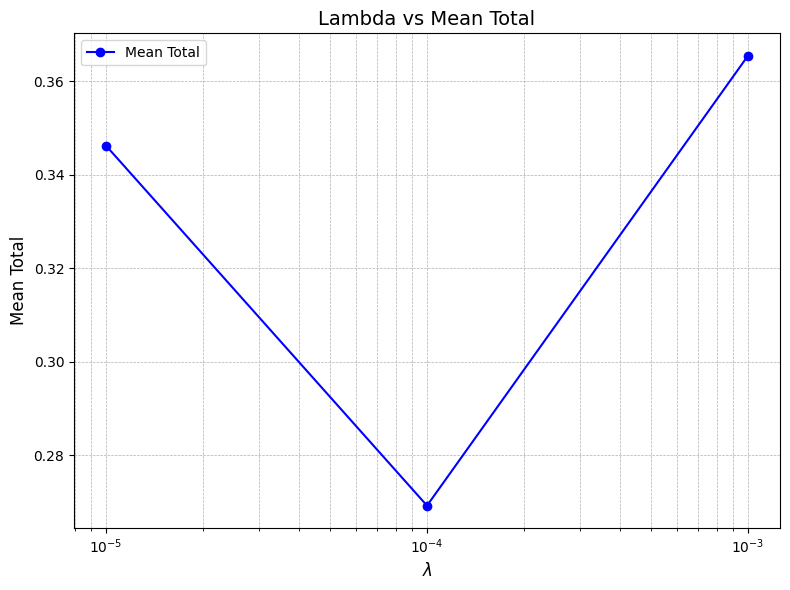

    lambda  mean_total  mean_group1  mean_group2
0  0.00100    0.365385     0.384615     0.346154
1  0.00010    0.269231     0.230769     0.307692
2  0.00001    0.346154     0.384615     0.307692
El mejor valor de lambda es: 0.001


In [23]:
import pandas as pd
import matplotlib.pyplot as plt  # Corrección en la importación
from scipy.stats import f_oneway
import numpy as np  # Se importa numpy para manejo de NaN

# Calcular métricas por lambda
summary_results = []
for lambda_val in lambdas:
    lambda_results = [result for result in all_results if result["lambda"] == lambda_val]
    
    group1_acc = [result["best_val_acc"] for result in lambda_results if result["fold"] < n_splits]
    group2_acc = [result["best_val_acc"] for result in lambda_results if result["fold"] >= n_splits]
    
    mean_group1 = np.nanmean(group1_acc) if group1_acc else np.nan
    mean_group2 = np.nanmean(group2_acc) if group2_acc else np.nan

    # Evitar cálculos con NaN
    if not np.isnan(mean_group1) and not np.isnan(mean_group2):
        mean_total = (mean_group1 + mean_group2) / 2
    else:
        mean_total = np.nan
    
    summary_results.append({
        "lambda": lambda_val,
        "mean_total": mean_total,
        "mean_group1": mean_group1,
        "mean_group2": mean_group2,
    })

# Convertir resultados en DataFrame
summary_df = pd.DataFrame(summary_results)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(summary_df["lambda"], summary_df["mean_total"], marker="o", linestyle="-", color="b", label="Mean Total")

# Configurar el eje x en escala logarítmica
plt.xscale("log")

# Añadir etiquetas y título
plt.xlabel(r"$\lambda$", fontsize=12)
plt.ylabel("Mean Total", fontsize=12)
plt.title("Lambda vs Mean Total", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar tabla de resultados
print(summary_df)

# Determinar el mejor lambda basado en el mayor valor de mean_total
if summary_df["mean_total"].notna().sum() > 0:  # Verificar que hay valores válidos
    best_lambda_row = summary_df.loc[summary_df["mean_total"].idxmax()]
    best_lambda = best_lambda_row["lambda"]
    print(f"El mejor valor de lambda es: {best_lambda}")
else:
    print("No hay valores válidos para seleccionar el mejor lambda.")


### Modelo con el mejor lambda

In [24]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()
predict_dataset = data_module.predict_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lambda)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [25]:
epochs = 2  # Número de épocas

checkpoint_dir = f"checkpoints/i3d_model"
os.makedirs(checkpoint_dir, exist_ok=True)

# Crear los callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_best"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

history = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop_callback, checkpoint_callback],
    verbose=1
)

Epoch 1/2


2025-03-29 20:37:07.840251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-03-29 20:37:12.955509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 616s 83s/step - loss: 1.1172 - accuracy: 0.5577 - val_loss: 1.0719 - val_accuracy: 0.3333
Epoch 2/2


2025-03-29 20:47:10.083513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-03-29 20:47:15.198312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 601s 83s/step - loss: 0.7321 - accuracy: 0.5962 - val_loss: 1.1781 - val_accuracy: 0.5000


In [26]:
train_loss, train_acc = model_1.evaluate(train_dataset, verbose=1)

2025-03-29 20:57:10.936313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-03-29 20:57:16.093689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 22s 915ms/step - loss: 0.8267 - accuracy: 0.5385


In [27]:
# Evaluar en el conjunto de validación
val_loss, val_acc = model_1.evaluate(val_dataset, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 1.1781 - accuracy: 0.5000


In [28]:
# Evaluar en el conjunto de prueba
test_loss, test_acc = model_1.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.6163 - accuracy: 0.7143


### Gráfica Epochs vs Loss

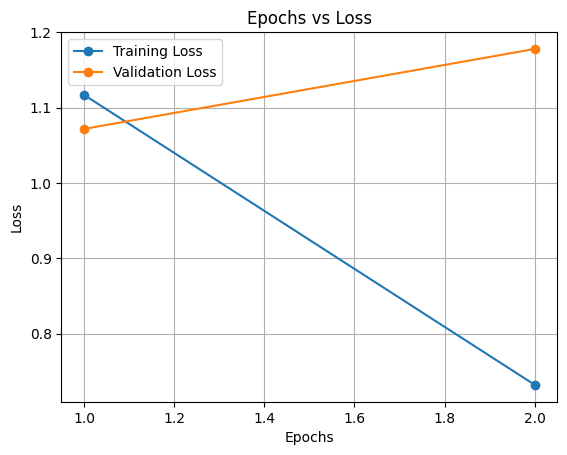

In [29]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 7, Usando perplexity=6


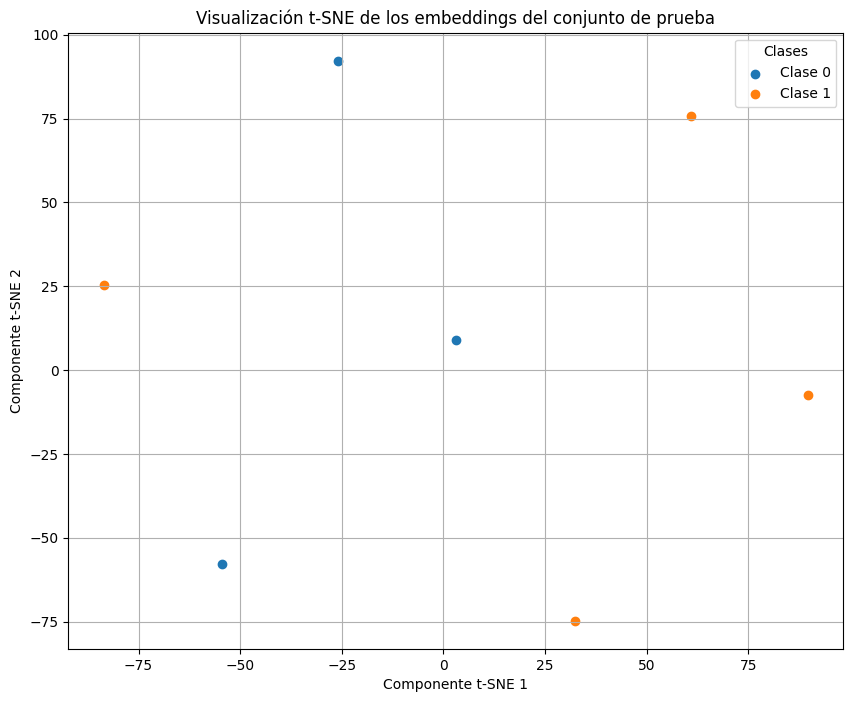

In [30]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## I3D + ConvLSTM2D

In [31]:
from tensorflow.keras.layers import ConvLSTM2D, TimeDistributed, Dense, Flatten
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar la información temporal
        self.conv_lstm = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=False)
        
        # Capa completamente conectada final
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        """
        Entrada esperada: (batch_size, num_frames, height, width, channels)
        """
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, channels)

        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, 7, 7, 64)

        # Aplanar y pasar por la capa de salida
        x = Flatten()(lstm_out)
        logits = self.fc(x)

        return logits

In [32]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()
predict_dataset = data_module.predict_dataset()

### Implementación de Repeated K-Fold Cross Validation

In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir los parámetros
num_classes = 2
n_splits = 2 #5
n_repeats = 1 #2
batch_size = 8
frame_size = (224, 224)
num_frames = 32

# Configuración de Repeated K-Fold Cross-Validation
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Lista de resultados
all_results = []
lambdas = [1e-3, 1e-4, 1e-5]


X = train_df.drop(columns=["is_crime"]).values  # Características
y = train_df["is_crime"].values  # Etiquetas

In [34]:

for i, lambda_val in enumerate(lambdas):
    for repeat, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
        fold = repeat % n_splits + 1
        repeat_num = repeat // n_splits + 1

        print(f"Entrenando con lambda={lambda_val} | Repeat {repeat_num} | Fold {fold}")

        # Dividir los datos
        train_data = train_df.iloc[train_idx]
        val_data = train_df.iloc[val_idx]

        # Crear DataModule con los datos divididos
        data_module = VideoDataModule(train_data, val_data, test_df, batch_size, frame_size, num_frames)

        # Obtener datasets
        train_dataset = data_module.train_dataset()
        val_dataset = data_module.val_dataset()

        # Crear modelo adaptado a Keras
        model = I3D_ConvLSTM(num_classes=num_classes)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lambda_val)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

        # Crear directorio de checkpoints
        checkpoint_dir = f"./checkpoints/hibrid_lambda{i}_repeat{repeat_num}_fold{fold}"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Callbacks
        early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True)
        checkpoint_callback = ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, "model_best"),
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            save_weights_only=True  # ✅ Guardar solo pesos
        )

        # Entrenar el modelo
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=1,
            callbacks=[early_stop_callback, checkpoint_callback],
            verbose=1
        )

        # Guardar los resultados
        best_val_loss = min(history.history["val_loss"])
        best_val_acc = max(history.history["val_accuracy"])
        all_results.append({
            "lambda": lambda_val,
            "repeat": repeat_num,
            "fold": fold,
            "best_val_loss": best_val_loss,
            "best_val_acc": best_val_acc,
            "best_checkpoint": os.path.join(checkpoint_dir, "model_best")
        })

print("Entrenamiento finalizado.")

Entrenando con lambda=0.001 | Repeat 1 | Fold 1


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


4/4 [==============================] - 326s 71s/step - loss: 1.2068 - accuracy: 0.5385 - val_loss: 0.9968 - val_accuracy: 0.3077
Entrenando con lambda=0.001 | Repeat 1 | Fold 2
4/4 [==============================] - 327s 71s/step - loss: 2.0848 - accuracy: 0.4615 - val_loss: 0.7373 - val_accuracy: 0.5000
Entrenando con lambda=0.0001 | Repeat 1 | Fold 1


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


4/4 [==============================] - 327s 72s/step - loss: 1.0170 - accuracy: 0.4231 - val_loss: 0.9707 - val_accuracy: 0.3846
Entrenando con lambda=0.0001 | Repeat 1 | Fold 2
4/4 [==============================] - 326s 71s/step - loss: 0.7308 - accuracy: 0.5000 - val_loss: 1.3224 - val_accuracy: 0.3846
Entrenando con lambda=1e-05 | Repeat 1 | Fold 1


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


4/4 [==============================] - 325s 72s/step - loss: 0.7685 - accuracy: 0.4231 - val_loss: 0.7191 - val_accuracy: 0.4615
Entrenando con lambda=1e-05 | Repeat 1 | Fold 2
4/4 [==============================] - 326s 71s/step - loss: 0.7034 - accuracy: 0.5769 - val_loss: 0.7991 - val_accuracy: 0.3846
Entrenamiento finalizado.


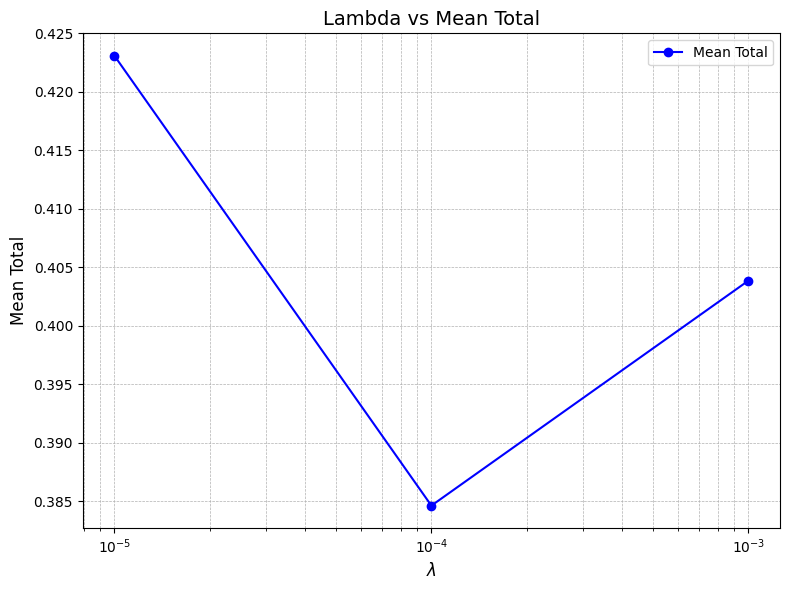

    lambda  mean_total  mean_group1  mean_group2
0  0.00100    0.403846     0.307692     0.500000
1  0.00010    0.384615     0.384615     0.384615
2  0.00001    0.423077     0.461538     0.384615
El mejor valor de lambda es: 1e-05


In [35]:
import pandas as pd
import matplotlib.pyplot as plt  # Corrección en la importación
from scipy.stats import f_oneway
import numpy as np  # Se importa numpy para manejo de NaN

# Calcular métricas por lambda
summary_results = []
for lambda_val in lambdas:
    lambda_results = [result for result in all_results if result["lambda"] == lambda_val]
    
    group1_acc = [result["best_val_acc"] for result in lambda_results if result["fold"] < n_splits]
    group2_acc = [result["best_val_acc"] for result in lambda_results if result["fold"] >= n_splits]
    
    mean_group1 = np.nanmean(group1_acc) if group1_acc else np.nan
    mean_group2 = np.nanmean(group2_acc) if group2_acc else np.nan

    # Evitar cálculos con NaN
    if not np.isnan(mean_group1) and not np.isnan(mean_group2):
        mean_total = (mean_group1 + mean_group2) / 2
    else:
        mean_total = np.nan
    
    summary_results.append({
        "lambda": lambda_val,
        "mean_total": mean_total,
        "mean_group1": mean_group1,
        "mean_group2": mean_group2,
    })

# Convertir resultados en DataFrame
summary_df = pd.DataFrame(summary_results)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(summary_df["lambda"], summary_df["mean_total"], marker="o", linestyle="-", color="b", label="Mean Total")

# Configurar el eje x en escala logarítmica
plt.xscale("log")

# Añadir etiquetas y título
plt.xlabel(r"$\lambda$", fontsize=12)
plt.ylabel("Mean Total", fontsize=12)
plt.title("Lambda vs Mean Total", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar tabla de resultados
print(summary_df)

# Determinar el mejor lambda basado en el mayor valor de mean_total
if summary_df["mean_total"].notna().sum() > 0:  # Verificar que hay valores válidos
    best_lambda_row = summary_df.loc[summary_df["mean_total"].idxmax()]
    best_lambda = best_lambda_row["lambda"]
    print(f"El mejor valor de lambda es: {best_lambda}")
else:
    print("No hay valores válidos para seleccionar el mejor lambda.")


### Modelo con el mejor lambda

In [36]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()
predict_dataset = data_module.predict_dataset()

model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lambda)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [37]:
epochs = 2  # Número de épocas

checkpoint_dir = f"checkpoints/i3d_conv_model"
os.makedirs(checkpoint_dir, exist_ok=True)

# Crear los callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_best"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

history = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop_callback, checkpoint_callback],
    verbose=1
)

Epoch 1/2


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2025-03-29 21:30:42.520081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-03-29 21:30:47.625360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 617s 83s/step - loss: 0.7100 - accuracy: 0.5385 - val_loss: 0.7257 - val_accuracy: 0.5000
Epoch 2/2


2025-03-29 21:40:45.206500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-03-29 21:40:50.470411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 598s 82s/step - loss: 0.6064 - accuracy: 0.6538 - val_loss: 0.7185 - val_accuracy: 0.5000


In [38]:
train_loss, train_acc = model_2.evaluate(train_dataset, verbose=1)

2025-03-29 21:50:43.658841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 52
2025-03-29 21:50:48.763458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


7/7 [==============================] - 22s 906ms/step - loss: 0.5404 - accuracy: 0.8462


In [39]:
# Evaluar en el conjunto de validación
val_loss, val_acc = model_2.evaluate(val_dataset, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.7185 - accuracy: 0.5000


In [40]:
# Evaluar en el conjunto de prueba
test_loss, test_acc = model_2.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.8494 - accuracy: 0.1429


### Gráfica Epochs vs Loss

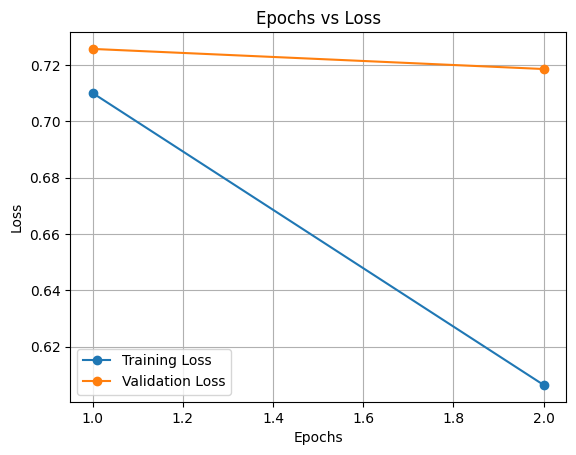

In [41]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 7, Usando perplexity=6


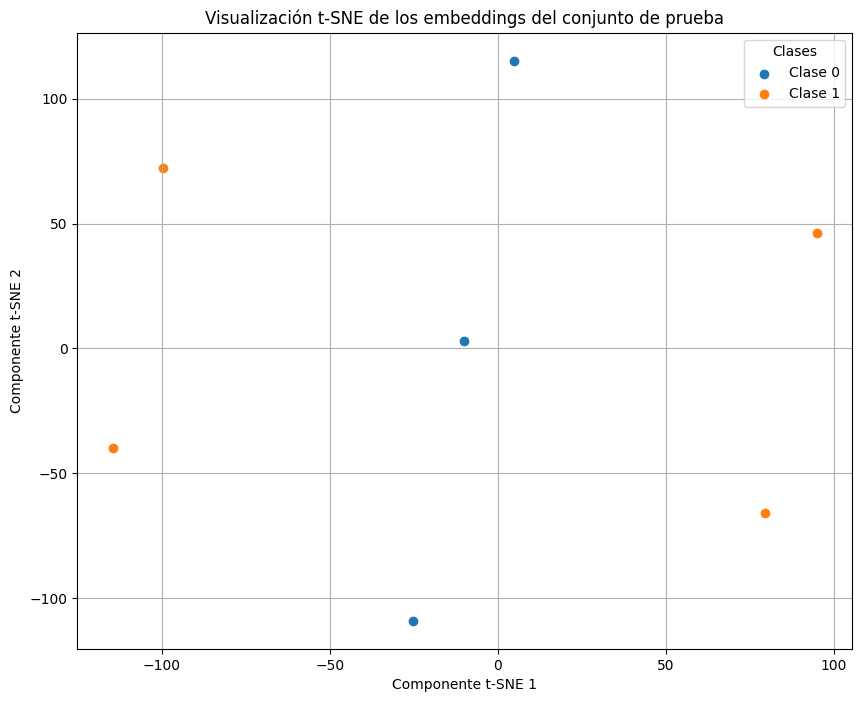

In [42]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [43]:
# Evaluar los modelos en el conjunto de prueba
loss_1, acc_1 = model_1.evaluate(X_test, y_test)
loss_2, acc_2 = model_2.evaluate(X_test, y_test)

print(f"KerasI3D - Loss: {loss_1}, Accuracy: {acc_1}")
print(f"I3D_ConvLSTM - Loss: {loss_2}, Accuracy: {acc_2}")

NameError: name 'X_test' is not defined